# Assignment 2 Stochastic Simulation
Created on 15:13:12, 25-11-2021

Florian Tiggeloven 11872802 & Lars Grim 113511157

This programme is used for calculating the mean waiting time for different existant models of queueing theory 

## Imported Functions

Importing the necessary functions used in this program

In [1]:
import numpy as np
import random
import simpy 
import os
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import csv
import pandas as pd
from datetime import datetime
from datetime import date

In [4]:
class queue:
    """An object representing a queue
     takes different values for different types of
     queues and saves the data after simulation"""
    def __init__(self, run_number, in_time, help_time, num_assistant, duration, prio, quest):
        self.env = simpy.Environment()
        self.in_time = in_time
        self.help_time = help_time
        self.run_number = run_number
        self.duration = duration
        self.assistant = simpy.PriorityResource(self.env, capacity = num_assistant)
        self.num_assistant = num_assistant
        self.queue_time_list = []
        self.results_df = pd.DataFrame()
        self.results_df["Caller_ID"] = []
        self.results_df["time_queuing"] = []
        self.results_df.set_index("Caller_ID", inplace=True)
        self.quest = quest
        self.prio = prio
    
    def customer_generator(self):
        """"Function generating a customer with customer number at 
        a random time based on the arrival time (in_time)"""
        caller_id = 0
        while True:
            arr = self.arrival_generator(caller_id)  # get new caller

            self.env.process(arr)  # get simpy environment with this caller

            interarrival = random.expovariate(1.0/self.in_time) # randomly sample the time to next caller

            yield self.env.timeout(interarrival)  # freeze function until time has elapsed
            caller_id += 1


    def arrival_generator(self, caller_id):
        """"Function generating an arrival using the customer function  
        with a random time needed to assist based on the service time (help_time)"""
        s = np.random.uniform(0,1)
        time_entered_queue = self.env.now
        if self.quest == "Longtail" and s > 0.75:
            prio = sample_help_time = round(random.expovariate(1.0/5.0),2)
        elif self.quest == "Determinant":
            prio = sample_help_time = self.help_time
        else:
            prio = sample_help_time = round(random.expovariate(1.0/self.help_time),2)
        # request caller assistant
        if self.prio == True:
            with self.assistant.request(priority=prio) as req:
                yield req

                time_left_queue = self.env.now
                #print(f"Caller {caller_id} left queue at {round(time_left_queue,2)} minutes")

                time_in_queue = (time_left_queue - time_entered_queue)

                df_to_add = pd.DataFrame({"Caller_ID":[caller_id], "time_queuing":[time_in_queue]})
                df_to_add.set_index("Caller_ID", inplace=True)
                self.results_df = self.results_df.append(df_to_add)

                yield self.env.timeout(sample_help_time)
                self.queue_time_list.append(time_in_queue)

        else:
            with self.assistant.request() as req:
                yield req

                time_left_queue = self.env.now
                #print(f"Caller {caller_id} left queue at {round(time_left_queue,2)} minutes")

                time_in_queue = (time_left_queue - time_entered_queue)

                df_to_add = pd.DataFrame({"Caller_ID":[caller_id], "time_queuing":[time_in_queue]})
                df_to_add.set_index("Caller_ID", inplace=True)
                self.results_df = self.results_df.append(df_to_add)

                yield self.env.timeout(sample_help_time)
                self.queue_time_list.append(time_in_queue)



    def meantime_queue(self):
        "Function that takes the mean of all queue times from the global list"
        self.meantime = self.results_df["time_queuing"].mean()


    def save_results_servers(self):
        "Function that saves the mean queue time data in a file"
        now = datetime.now()
        today = date.today()
        d1 = today.strftime("%d/%m/%Y")
        current_time = now.strftime("%H:%M:%S")
        with open(f"Serverdata{self.prio}{self.quest}All.csv", "a") as f:
            writer = csv.writer(f, delimiter=",")
            results_to_write = [self.num_assistant, self.run_number, self.meantime]
            writer.writerow(results_to_write)
    
    def save_results_boxdep(self):
        "Function that saves the mean queue time data in a file specifically for the boxplot function"
        now = datetime.now()
        today = date.today()
        d1 = today.strftime("%d/%m/%Y")
        current_time = now.strftime("%H:%M:%S")
        with open(f"Boxdata{self.prio}{self.quest}{self.num_assistant}.csv", "a") as f:
            writer = csv.writer(f, delimiter=",")
            results_to_write = [self.num_assistant, self.run_number, self.meantime]
            writer.writerow(results_to_write)

    def run(self):
        "Function used to run the simpy process placed in the arrival function"
        self.env.process(self.customer_generator())

        self.env.run(until=self.duration)

        #print(self.results_df)



## Functions for generating data

In [5]:
def servergenerate(ptype,qtype):
    "Function defined to generate different types of data from the queue class"
    servers = [1,2,4]
    for server in servers:
        for run in range(1,total_runs):
            #print(f"n: {run}")
            current_model = queue(run, (lamda/server), mu, server, duration,ptype,f"{qtype}")
            current_model.run()
            current_model.meantime_queue()
            current_model.save_results_servers()

def bservergenerate(ptype,qtype):
    "Function defined to generate different types of data from the queue class"
    "specifically for boxlotting"
    servers=[1,2,4]
    for server in servers:
        for run in range(1,total_runs+1):
            current_model = queue(run, (lamda/server), mu, server, duration,ptype,f"{qtype}")
            current_model.run()
            current_model.meantime_queue()
            current_model.save_results_boxdep()

## Functions for plotting data

In [6]:
def serverplot(ptype,qtype):
    "Function used for the plotting of the generated data"
    servertest = pd.read_csv(f'Serverdata{ptype}{qtype}All.csv',names=['Servers','Run_number','MeanTime'])
    x,y,yerr=[],[],[]
    N=np.array([1,2,4])
    for i in N:
        yerr.append(np.std(servertest[servertest["Servers"]==i]['MeanTime']))
        y.append(np.mean(servertest[servertest["Servers"]==i]['MeanTime']))
    x=N#np.arange(N)
    xname = ['n=1','n=2','n=4']
    y=np.array(y)
    plt.plot(x,y)
    plt.fill_between(x,(np.array(y)-np.array(yerr)),(np.array(y)+np.array(yerr)),alpha=0.25,label=f'{qtype}')
    plt.xlabel('Servers')
    plt.xticks(x,xname)
    plt.ylabel('Mean Time waiting')


def boxplot(ptype,qtype,N):
    "Function used for plotting of the generated boxplot data"
    servertest = pd.read_csv(f'Boxdata{ptype}{qtype}{N}.csv',names=['Servers','Run_number','MeanTime'])
    x,y,yerr=[],[],[]
    for i in range(N):
        y.append((servertest['MeanTime']))
    x=np.arange(N)
    y=np.array(y)
    return (y[~np.isnan(y)])

In [ ]:
# Cell used for generating the data that was used
# This is placed in brackets to prevent new data from being created

#     servergenerate(False,'Exponential')
#     servergenerate(False,'Determinant')
#     servergenerate(False,'Longtail')
#     servergenerate(True,'Exponential')

## Plotting Cells

T-test between n=1 and n=2 yields a p-value of 0.4088465333194041
T-test between n=1 and n=4 yields a p-value of 0.3514878869195718
T-test between n=2 and n=4 yields a p-value of 0.0035139145671688834


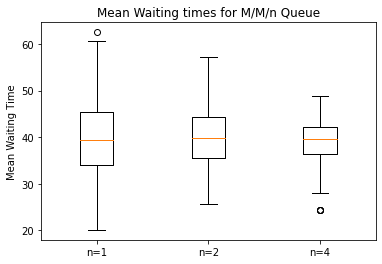

In [7]:
# Cell using the plotting functions to create the boxplot used in the paper
fig,ax = plt.subplots()
n1= boxplot('False','Exponential',1)
n2= boxplot('False','Exponential',2)
n4= boxplot('False','Exponential',4)
plotdata =[n1,n2,n4]
ax.boxplot(plotdata,labels=('n=1','n=2','n=4'))
ax.set_ylabel('Mean Waiting Time')
ax.set_title("Mean Waiting times for M/M/n Queue")
print('T-test between n=1 and n=2 yields a p-value of',stats.ttest_ind(n1,n2)[1])
print('T-test between n=1 and n=4 yields a p-value of',stats.ttest_ind(n1,n4)[1])
print('T-test between n=2 and n=4 yields a p-value of',stats.ttest_ind(n2,n4)[1])
#plt.savefig('BoxplotN124.png')
plt.show()

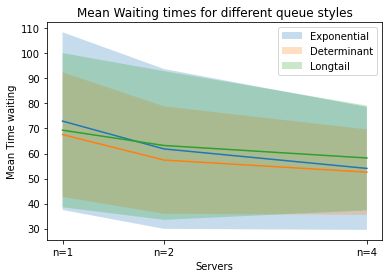

In [8]:
# Cell using the plotting functions to create the lineplot used in the paper
fig,ax = plt.subplots()
serverplot('False','Exponential')
serverplot('False','Determinant')
serverplot('False','Longtail')
plt.title('Mean Waiting times for different queue styles')
#plt.yticks(np.arange(0,30,5))
plt.legend()
#plt.savefig('AllQstylesNoP.png')
plt.show()

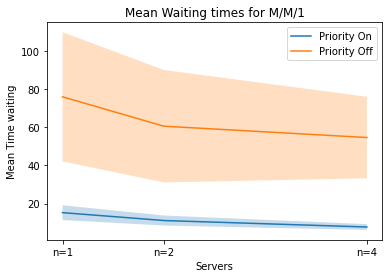

In [9]:
# Cell using the plotting functions to create the lineplot of priority used in the paper
fig,ax = plt.subplots()
serverplot('True','ExponentialP')
serverplot('False','ExponentialP')
plt.title('Mean Waiting times for M/M/1')
#plt.yticks(np.arange(0,30,5))
plt.legend(['Priority On','Priority Off'])
#plt.savefig('BothPstylesExp.png')
plt.show()

## Independant T-tests

In the cells below, p-values of the data were calculated using the scipy function

In [14]:
yE,yD,yL,Yp,Ynp =[],[],[],[],[]
N=np.array([1,2,4])

dataP = pd.read_csv(f'ServerdataFalseExponentialPAll.csv',names=['Servers','Run_number','MeanTime'])
dataNP = pd.read_csv(f'ServerdataTrueExponentialPAll.csv',names=['Servers','Run_number','MeanTime'])

Bdat1 = pd.read_csv(f'BoxdataFalseExponential1.csv',names=['Servers','Run_number','MeanTime'])
Bdat2 = pd.read_csv(f'BoxdataFalseExponential2.csv',names=['Servers','Run_number','MeanTime'])
Bdat4 = pd.read_csv(f'BoxdataFalseExponential4.csv',names=['Servers','Run_number','MeanTime'])

b1 = Bdat1["MeanTime"]
b2 = Bdat2["MeanTime"]
b4 = Bdat4["MeanTime"]

dataE = pd.read_csv(f'ServerdataFalseExponentialAll.csv',names=['Servers','Run_number','MeanTime'])
dataD = pd.read_csv(f'ServerdataFalseDeterminantAll.csv',names=['Servers','Run_number','MeanTime'])
dataL = pd.read_csv(f'ServerdataFalseLongtailAll.csv',names=['Servers','Run_number','MeanTime'])



for i in N:
    yE.append(np.mean(dataE[dataE["Servers"]==i]['MeanTime']))
    yD.append(np.mean(dataD[dataD["Servers"]==i]['MeanTime']))
    yL.append(np.mean(dataL[dataL["Servers"]==i]['MeanTime']))
    Yp.append(np.mean(dataP[dataP["Servers"]==i]['MeanTime']))
    Ynp.append(np.mean(dataNP[dataNP["Servers"]==i]['MeanTime']))

yE = np.array(yE)[~np.isnan(yE)]
yD = np.array(yD)[~np.isnan(yD)]
yL = np.array(yL)[~np.isnan(yL)]
Yp = np.array(Yp)[~np.isnan(Yp)]
Ynp = np.array(Ynp)[~np.isnan(Ynp)]

In [15]:
print('T-test between priority and no priority for Exponential returned','T-value=',stats.ttest_ind(Yp,Ynp)[0],'p-value=',stats.ttest_ind(Yp,Ynp)[1])

T-test between priority and no priority for Exponential returned T-value= 7.790436813573685 p-value= 0.001464343805501727


In [16]:
print('T-test between n=1 and n=2 for Exponential returned','T-value=',stats.ttest_ind(b1,b2)[0],'p-value=',stats.ttest_ind(b1,b2)[1])
print('T-test between n=2 and n=4 for Exponential returned','T-value=',stats.ttest_ind(b2,b4)[0],'p-value=',stats.ttest_ind(b2,b4)[1])
print('T-test between n=1 and n=4 for Exponential returned','T-value=',stats.ttest_ind(b1,b4)[0],'p-value=',stats.ttest_ind(b1,b4)[1])

T-test between n=1 and n=2 for Exponential returned T-value= -0.6780706740787339 p-value= 0.49805498356772593
T-test between n=2 and n=4 for Exponential returned T-value= 1.685715629177408 p-value= 0.09250318942961432
T-test between n=1 and n=4 for Exponential returned T-value= 0.5948056900044871 p-value= 0.552254812923382


In [17]:
print('T-test between Ex on and Det off yields','T-value',stats.ttest_ind(yE,yD)[0],'p-value',stats.ttest_ind(yE,yD)[1])
print('T-test between Det on and Longtail off yields','T-value',stats.ttest_ind(yD,yL)[0],'p-value',stats.ttest_ind(yD,yL)[1])
print('T-test between Ex on and Longtail off yields of','T-value',stats.ttest_ind(yE,yL)[0],'p-value',stats.ttest_ind(yE,yL)[1])

T-test between Ex on and Det off yields T-value 0.5345291383922995 p-value 0.6213040948165619
T-test between Det on and Longtail off yields T-value -0.8057134680981513 p-value 0.465577657570719
T-test between Ex on and Longtail off yields of T-value -0.10039542941865054 p-value 0.924861121646996
